In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone  https://github.com/ecastillot/delaware.git ./delaware
    !pip install obspy

In [2]:
import sys
import os

version = "10102024"

if 'google.colab' in sys.modules:
    dw_path = os.path.join("/content/delaware",version)
else:
    dw_path = os.path.join("/home/emmanuel/ecastillo/dev/delaware",version)
    
sys.path.append(dw_path)

In [3]:
from delaware.core.read import EQPicks
from delaware.core.eqviewer import Stations
from delaware.loc.inv import prepare_cat2vps
import pandas as pd
import os
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

def compute_vij(arrivals):
    # Ensure arrival times are in datetime format
    arrivals['arrival_time_P'] = pd.to_datetime(arrivals['arrival_time_P'])
    arrivals['arrival_time_S'] = pd.to_datetime(arrivals['arrival_time_S'])
    
    # List to store results
    results = []

    # Iterate over all combinations of row indices
    for i, j in combinations(arrivals.index, 2):
        # Compute v_ij
        delta_t_S = (arrivals.loc[i, 'arrival_time_S'] - arrivals.loc[j, 'arrival_time_S']).total_seconds()
        delta_t_P = (arrivals.loc[i, 'arrival_time_P'] - arrivals.loc[j, 'arrival_time_P']).total_seconds()
        
        if delta_t_P != 0:  # Avoid division by zero
            v_ij = delta_t_S / delta_t_P
            
            if v_ij > 0:
                
                results.append({
                    'station_i': arrivals.loc[i, 'station'],
                    'station_j': arrivals.loc[j, 'station'],
                    'v_ij': v_ij
                })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def plot_vij_histogram(vij_df, cluster,bins=20,output=None):
    """
    Plots a histogram of the v_ij values.

    Parameters:
        vij_df (pd.DataFrame): DataFrame containing v_ij values.
        bins (int): Number of bins for the histogram.
    """
    # Extract v_ij values
    v_ij_values = vij_df['v_ij']
    median = v_ij_values.quantile(0.5)
    
    # Plot the histogram using Seaborn
    plt.figure(figsize=(8, 5))
    sns.histplot(v_ij_values, bins=bins, kde=True, 
                #  stat="density",
                line_kws={'linewidth':2},
                 color='lightcoral', edgecolor='black')
    plt.axvline(x=median,color="black",linestyle='dashed')
    
    # Add the median value as text near the red line
    # plt.text(median-0.005, plt.gca().get_ylim()[1] * 0.5, f"median {median:.2f}", 
    #          color="black", fontsize=12, ha='center', va='center', 
    #          rotation=90)
    plt.text(0.95, 0.95, f"Median = {median:.2f}", 
             color="black", fontsize=12, ha='right', va='top', 
             transform=plt.gca().transAxes, 
            #  backgroundcolor="white"
             )
    
    # Add labels and title
    plt.title(f"R{cluster}", fontsize=16)
    plt.xlabel(r"${v_p}/{v_s}$", fontsize=14)
    plt.ylabel("Counts", fontsize=14)
    
    # Show the plot
    plt.grid(alpha=0.3)
    if output is not None:
        plt.savefig(output, dpi=300, bbox_inches='tight')
    plt.show()

# c1

In [4]:
c1 = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/clusters/C1.bna"
root = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust"
catalog_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/clusters/eq_c1.csv"
picks_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/picks.db"
author = "growclust"
proj = "EPSG:3857"
stations_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/stations/standard_stations.csv"

stations = pd.read_csv(stations_path)
stations_columns = ["network","station","latitude","longitude","elevation","x[km]","y[km]"]
stations = stations[stations_columns]
stations["station_index"] = stations.index
stations = Stations(data=stations,xy_epsg=proj)


c1 =pd.read_csv(c1)
c1 = list(zip(c1['lon'], c1['lat']))

eqpicks = EQPicks(root,author=author,
                      xy_epsg=proj,
                      catalog_path=catalog_path,
                      picks_path=picks_path
                      )
stations.filter_general_region(c1)
cat,picks = eqpicks.get_catalog_with_picks(
                                        general_region=c1
                                           )
cat,picks = prepare_cat2vps(cat.data,picks.data,stations.data)
# print(picks)

all_vps = []
picks = picks.groupby(by="ev_id")
for ev_id, arrivals in picks.__iter__():
    vij_results = compute_vij(arrivals)

    if vij_results.empty:
        continue
    else:
        vij_median = vij_results["v_ij"].median()

    all_vps.append((ev_id,vij_median))
vps = pd.DataFrame(all_vps, columns=["ev_id", "v_ij"])      

cat = pd.merge(cat,vps,how="inner",on="ev_id")
cat.describe()

Catalog | 4742 events 
Catalog | 4742 events 
6141 tables not found


/home/emmanuel/ecastillo/dev/delaware/10102024/delaware/core/database.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_dataframes, ignore_index=True)


,origin_time,eq_latitude,eq_longitude,magnitude,v_ij
count,3140,3140.000000,3140.000000,3140.000000,3140.000000
mean,2022-10-04 01:49:27.201256704,31.672373,-104.431907,2.098436,1.696892
min,2020-09-14 09:18:47.932000,31.531330,-104.585570,-0.820000,0.018620
25%,2021-09-04 15:04:58.730749696,31.665340,-104.478850,1.750000,1.631259
50%,2022-09-26 01:26:13.834499840,31.674865,-104.411595,2.040000,1.715431
75%,2023-11-07 21:46:24.550500096,31.678170,-104.390568,2.350000,1.774616
max,2024-04-24 00:42:05.557999,31.812120,-104.150700,4.930000,16.000218
std,NaN,0.027152,0.062480,0.523370,0.404515


                         origin_time  eq_latitude  eq_longitude    magnitude  \
count                           2512  2512.000000   2512.000000  2512.000000   
mean   2022-11-09 14:37:38.156430080    31.670308   -104.428924     2.094769   
min       2020-09-14 09:18:47.932000    31.531330   -104.582940    -0.470000   
25%    2021-09-28 14:14:29.695249152    31.665055   -104.459755     1.750000   
50%    2023-02-24 10:57:26.215999488    31.674610   -104.410850     2.030000   
75%    2023-11-16 14:08:11.581999104    31.677650   -104.392740     2.340000   
max       2024-04-24 00:42:05.557999    31.762770   -104.150700     4.930000   
std                              NaN     0.024784      0.057730     0.513851   

              v_ij  
count  2512.000000  
mean      1.702333  
min       1.470269  
25%       1.654397  
50%       1.715431  
75%       1.761905  
max       1.837662  
std       0.081017  


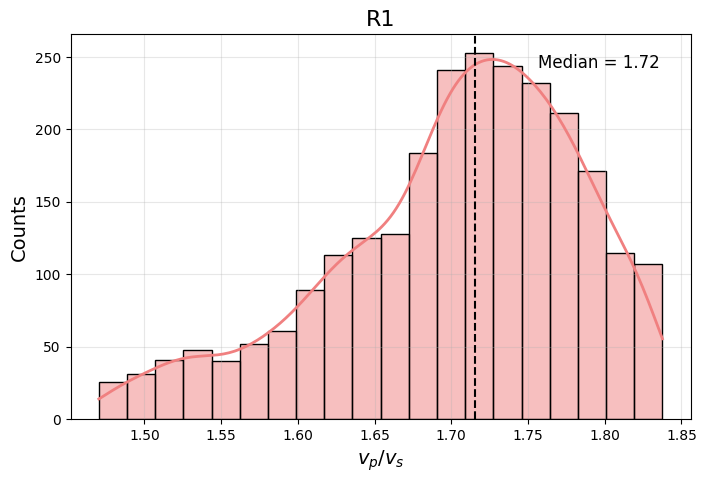

In [5]:
cluster = 1

output = os.path.join(dw_path,f"data_git/clusters/vps_c{cluster}.csv")
cat.to_csv(output,index=False)

Q1 = cat['v_ij'].quantile(0.10)
Q3 = cat['v_ij'].quantile(0.90)
iqr_cat = cat[(cat['v_ij'] >= Q1) & (cat['v_ij'] <= Q3)]
print(iqr_cat.describe())
output = os.path.join(dw_path,f"script/vps/vps_c{cluster}.png")
plot_vij_histogram(iqr_cat,cluster,bins=20,output=output)

# c2

In [6]:
c1 = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/clusters/C2.bna"
root = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust"
catalog_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/clusters/eq_c2.csv"
picks_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/picks.db"
author = "growclust"
proj = "EPSG:3857"
stations_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/stations/standard_stations.csv"

stations = pd.read_csv(stations_path)
stations_columns = ["network","station","latitude","longitude","elevation","x[km]","y[km]"]
stations = stations[stations_columns]
stations["station_index"] = stations.index
stations = Stations(data=stations,xy_epsg=proj)


c1 =pd.read_csv(c1)
c1 = list(zip(c1['lon'], c1['lat']))

eqpicks = EQPicks(root,author=author,
                      xy_epsg=proj,
                      catalog_path=catalog_path,
                      picks_path=picks_path
                      )
stations.filter_general_region(c1)
cat,picks = eqpicks.get_catalog_with_picks(
                                        general_region=c1
                                           )
cat,picks = prepare_cat2vps(cat.data,picks.data,stations.data)
# print(picks)

all_vps = []
picks = picks.groupby(by="ev_id")
for ev_id, arrivals in picks.__iter__():
    vij_results = compute_vij(arrivals)

    if vij_results.empty:
        continue
    else:
        vij_median = vij_results["v_ij"].median()

    all_vps.append((ev_id,vij_median))
vps = pd.DataFrame(all_vps, columns=["ev_id", "v_ij"])      

cat = pd.merge(cat,vps,how="inner",on="ev_id")
cat.describe()

Catalog | 4885 events 
Catalog | 4885 events 
6588 tables not found


/home/emmanuel/ecastillo/dev/delaware/10102024/delaware/core/database.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_dataframes, ignore_index=True)


,origin_time,eq_latitude,eq_longitude,magnitude,v_ij
count,1819,1819.000000,1819.000000,1819.000000,1819.000000
mean,2023-06-24 12:23:25.625546496,31.643036,-104.229349,2.059742,1.732416
min,2021-12-08 16:24:10.473000,31.522830,-104.380550,-0.060000,0.427676
25%,2023-02-08 02:40:38.083499520,31.615275,-104.296685,1.770000,1.620779
50%,2023-09-24 17:35:09.928000,31.650070,-104.225590,2.020000,1.684210
75%,2024-01-07 11:40:51.297498880,31.669890,-104.173600,2.280000,1.749546
max,2024-04-24 16:04:04.320000,31.802610,-104.059690,4.300000,73.639332
std,NaN,0.043868,0.076144,0.434914,1.717807


                         origin_time  eq_latitude  eq_longitude    magnitude  \
count                           1455  1455.000000   1455.000000  1455.000000   
mean   2023-07-09 00:48:32.816308992    31.643024   -104.229815     2.058983   
min       2021-12-09 02:22:36.353000    31.522830   -104.380550    -0.060000   
25%    2023-02-27 18:19:26.421499136    31.615025   -104.296505     1.765000   
50%       2023-10-12 04:59:59.472000    31.650570   -104.225660     2.020000   
75%    2024-01-09 18:58:53.238000128    31.670125   -104.174735     2.280000   
max       2024-04-24 16:04:04.320000    31.754490   -104.059690     4.300000   
std                              NaN     0.044173      0.075326     0.425394   

              v_ij  
count  1455.000000  
mean      1.683819  
min       1.530482  
25%       1.635017  
50%       1.684210  
75%       1.735242  
max       1.824528  
std       0.068564  


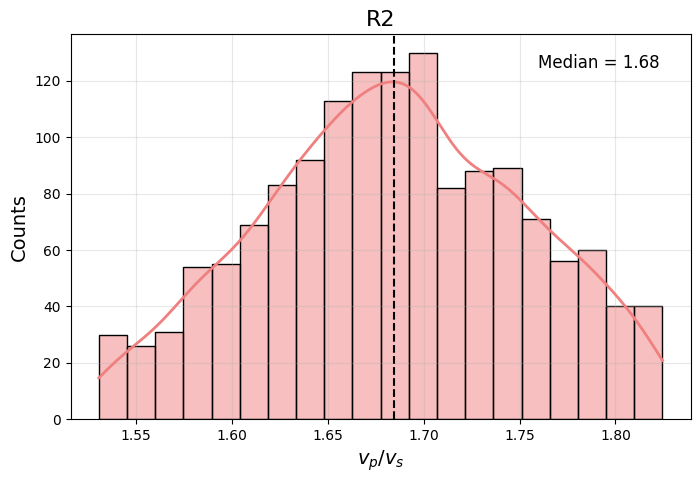

In [7]:
cluster = 2

output = os.path.join(dw_path,f"data_git/clusters/vps_c{cluster}.csv")
cat.to_csv(output,index=False)

Q1 = cat['v_ij'].quantile(0.10)
Q3 = cat['v_ij'].quantile(0.90)
iqr_cat = cat[(cat['v_ij'] >= Q1) & (cat['v_ij'] <= Q3)]
print(iqr_cat.describe())
output = os.path.join(dw_path,f"script/vps/vps_c{cluster}.png")
plot_vij_histogram(iqr_cat,cluster,bins=20,output=output)

# c3

In [8]:
c1 = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/clusters/C3.bna"
root = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust"
catalog_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/clusters/eq_c3.csv"
picks_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/picks.db"
author = "growclust"
proj = "EPSG:3857"
stations_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/stations/standard_stations.csv"

stations = pd.read_csv(stations_path)
stations_columns = ["network","station","latitude","longitude","elevation","x[km]","y[km]"]
stations = stations[stations_columns]
stations["station_index"] = stations.index
stations = Stations(data=stations,xy_epsg=proj)


c1 =pd.read_csv(c1)
c1 = list(zip(c1['lon'], c1['lat']))

eqpicks = EQPicks(root,author=author,
                      xy_epsg=proj,
                      catalog_path=catalog_path,
                      picks_path=picks_path
                      )
stations.filter_general_region(c1)
cat,picks = eqpicks.get_catalog_with_picks(
                                        general_region=c1
                                           )
cat,picks = prepare_cat2vps(cat.data,picks.data,stations.data)
# print(picks)

all_vps = []
picks = picks.groupby(by="ev_id")
for ev_id, arrivals in picks.__iter__():
    vij_results = compute_vij(arrivals)

    if vij_results.empty:
        continue
    else:
        vij_median = vij_results["v_ij"].median()

    all_vps.append((ev_id,vij_median))
vps = pd.DataFrame(all_vps, columns=["ev_id", "v_ij"])      

cat = pd.merge(cat,vps,how="inner",on="ev_id")
cat.describe()

Catalog | 3263 events 
Catalog | 3263 events 
7442 tables not found


/home/emmanuel/ecastillo/dev/delaware/10102024/delaware/core/database.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_dataframes, ignore_index=True)


,origin_time,eq_latitude,eq_longitude,magnitude,v_ij
count,1953,1953.000000,1953.000000,1953.000000,1953.000000
mean,2023-02-20 08:58:53.836271872,31.620960,-104.017411,2.041941,1.681064
min,2021-02-13 10:49:17.548999,31.429460,-104.164110,-0.170000,0.240580
25%,2022-05-14 12:47:04.760999936,31.603620,-104.026060,1.710000,1.617396
50%,2023-07-29 15:21:53.615000064,31.612160,-104.002410,1.970000,1.681529
75%,2023-12-07 02:51:52.351998976,31.639020,-103.979580,2.280000,1.736842
max,2024-04-26 02:42:14.877000,31.751630,-103.835610,5.230000,7.525922
std,NaN,0.061636,0.058545,0.483582,0.257208


                         origin_time  eq_latitude  eq_longitude    magnitude  \
count                           1561  1561.000000   1561.000000  1561.000000   
mean   2023-04-01 13:33:20.849281792    31.622876   -104.018671     2.061294   
min       2021-02-13 16:21:32.286000    31.429460   -104.164110    -0.170000   
25%       2022-08-26 17:58:12.284000    31.603600   -104.026630     1.720000   
50%    2023-09-30 07:53:50.780998912    31.612120   -104.003310     1.990000   
75%    2023-12-13 09:59:27.187998976    31.642540   -103.979420     2.280000   
max       2024-04-26 02:42:14.877000    31.751040   -103.835610     4.450000   
std                              NaN     0.061938      0.058205     0.480176   

              v_ij  
count  1561.000000  
mean      1.677749  
min       1.534236  
25%       1.634238  
50%       1.681529  
75%       1.724191  
max       1.797866  
std       0.060925  


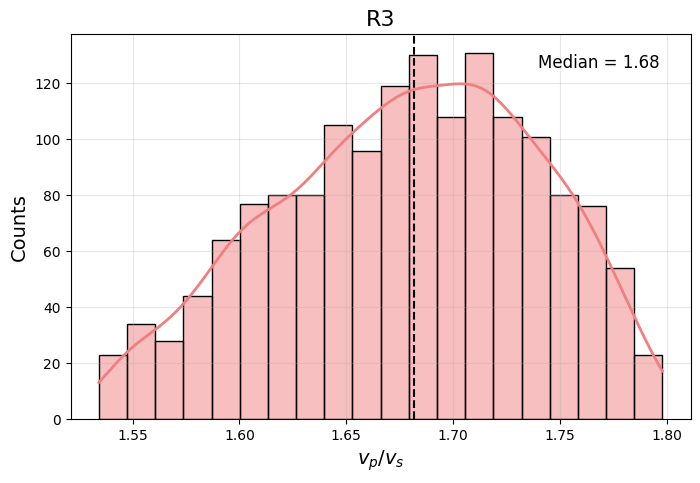

In [9]:
cluster = 3

output = os.path.join(dw_path,f"data_git/clusters/vps_c{cluster}.csv")
cat.to_csv(output,index=False)

Q1 = cat['v_ij'].quantile(0.10)
Q3 = cat['v_ij'].quantile(0.90)
iqr_cat = cat[(cat['v_ij'] >= Q1) & (cat['v_ij'] <= Q3)]
print(iqr_cat.describe())
output = os.path.join(dw_path,f"script/vps/vps_c{cluster}.png")
plot_vij_histogram(iqr_cat,cluster,bins=20,output=output)